# <font color=darkcyan>  L'algorithme EM pour un modèle de Markov caché discret </font>

Dans ce projet, on s'intéresse au modèle suivant: 

Soit $(X_k)_{0\leqslant k\leqslant n}$ une chaîne de Markov discrète à valeurs dans $E=\{1,\ldots,r\}$, de matrice de transition $Q$ et de loi initiale $\nu$. On considère que cette chaîne est uniquement observée au travers des variables $(Y_k)_{0\leqslant k\leqslant n}$ telles que conditionnellement à $(X_k)_{0\leqslant k\leqslant n}$,

- $(Y_k)_{{0\leqslant k\leqslant n}}$ sont indépendantes.
- $Y_k$ suit une loi gaussienne de moyenne $\mu_{X_k}$ et de variance $v_{X_k}$ pour tout ${0\leqslant k\leqslant n}$.

Le paramètre inconnu ici est $\theta = (\mu, v, \nu, Q)$ où $\mu = (\mu_1,\ldots,\mu_r )$, $v = (v_1,\ldots,v_r )$, $\nu = (\nu_1,\ldots,\nu_r )$ et $Q = (Q_{i, j})_{1\leqslant i, j \leqslant r}$.

On cherche donc à maximiser la vraisemblance $p_{\theta}(Y_{0:n})$ des variables observées $Y_{0:n}$. Ici, on choisit à utiliser l'algorithme EM pour résoudre ce problème.

1. On choisit $\theta^{(0)}$ arbitrairement.
2. Pour chaque $p \in \mathbb{N}$:
- E-step: On calcule

$$
Q(\theta^{(p)},\theta) =\mathbb{E}_{\theta^{(p)}}\left[\log p_{\theta}(X_{0:n},Y_{0:n})|Y_{0:n} \right].
$$
- M-step: On met à jour le paramètre:
$$
\theta^{(p+1)}\in \mbox{argmax}_\theta Q(\theta^{(p)}, \theta).
$$



In [1]:
# Required packages
import numpy as np
from numpy.random import default_rng
rng = default_rng()
from scipy import stats as stats
import matplotlib.pyplot as plt
import itertools

### <font color=darkorange> Simulation et visualisation des données </font>

In [2]:
# True values of parameters
r = 2
nu = np.ones(r)*1/r
mu = np.array([0., -2.])
v = np.array([1.0, 0.5])
Q = np.array([[0.4, 0.6],
              [0.8, 0.2]])

# Non-observed Markov chain
n_samples = 500
X = np.empty(n_samples, dtype=int)
X[0] = rng.choice(r, p=nu)
for i in range(n_samples-1):
    X[i+1] = rng.choice(r, p=Q[X[i]])
    
# Observations
samples = rng.normal(size=n_samples)
samples = mu[X] + np.sqrt(v[X])*samples

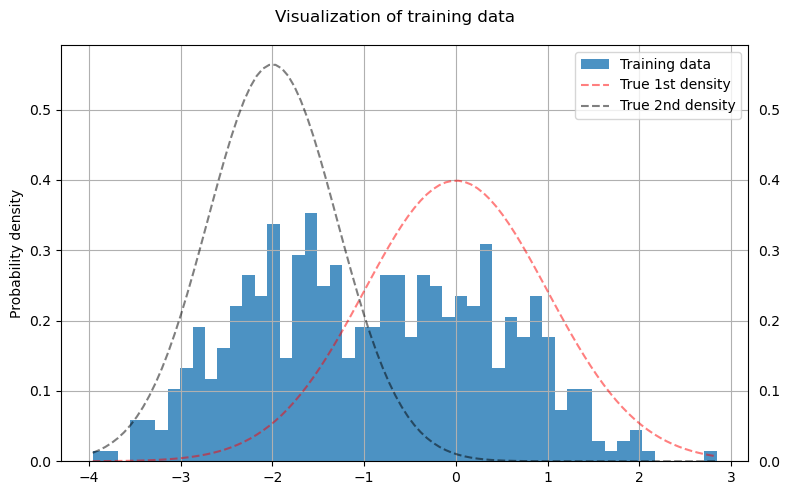

In [3]:
# Data visualization
bins = np.linspace(np.min(samples), np.max(samples), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5), layout='tight')
fig.suptitle('Visualization of training data')
ax.set_ylabel("Probability density")
ax.tick_params(labelright=True)
ax.grid('True')

ax.hist(samples, bins=50, density=True, alpha=0.8, label="Training data")

ax.plot(bins, stats.norm.pdf(bins, loc=mu[0], scale=np.sqrt(v[0])), linestyle = 'dashed', alpha = 0.5, color='red', label='True 1st density')
ax.plot(bins, stats.norm.pdf(bins, loc=mu[1], scale=np.sqrt(v[1])), linestyle = 'dashed', alpha = 0.5, color='k', label='True 2nd density')

ax.legend()

### <font color=darkorange> Calcul de la quantité intermédiaire </font>

Notons $\varphi_{\mu, v}$ la densité de la loi gaussienne de moyenne $\mu$ et de variance $v$, on a

$$\begin{align*}
\log p_\theta (X_{0:n},Y_{0:n}) &= \log p_\theta (X_{0:n}) + \log p_\theta (Y_{0:n}|X_{0:n}) \\ 
&=\log p_\theta (X_{0}) + \sum_{k=1}^n\log p_\theta (X_{k}|X_{k-1})+ \sum_{k=0}^n\log p_\theta(Y_k|X_k) \\ 
&= \sum_{i=1}^r\mathbb{1}_{X_0=i}\log \nu_i + \sum_{k=1}^n\sum_{i,j=1}^r\mathbb{1}_{X_{k-1}=i,X_k=j} \log Q_{i,j} + \sum_{k=0}^n\sum_{i=1}^r\mathbb{1}_{X_k=i}\log \varphi_{\mu_i,v_i}(Y_{k}). \nonumber
\end{align*}$$

Donc, la quantité intermédiaire de l'EM $Q(\theta',\theta)$ s'écrit:

Pour tout $\theta', \theta$,
$$\begin{align*}
Q(\theta',\theta) &= \mathbb{E}_{\theta'}\left[\log p_\theta (X_{0:n},Y_{0:n})\middle |Y_{0:n}\right]\\
&= \mathbb{E}_{\theta'}\left[ \sum_{i=1}^r\mathbb{1}_{X_0=i}\log \nu_i + \sum_{k=1}^n\sum_{i,j=1}^r\mathbb{1}_{X_{k-1}=i,X_k=j} \log Q_{i,j} + \sum_{k=0}^n\sum_{i=1}^r\mathbb{1}_{X_k=i}\log \varphi_{\mu_i,v_i}(Y_{k})\middle |Y_{0:n}\right]\\
&=\sum_{i=1}^r\mathbb{E}_{\theta'}\left[ \mathbb{1}_{X_0=i}\middle |Y_{0:n}\right]\log \nu_i + \sum_{k=1}^n\sum_{i,j=1}^r\mathbb{E}_{\theta'}\left[ \mathbb{1}_{X_{k-1}=i,X_k=j}\middle |Y_{0:n}\right] \log Q_{i,j} + \sum_{k=0}^n\sum_{i=1}^r\mathbb{E}_{\theta'}\left[ \mathbb{1}_{X_k=i}\middle |Y_{0:n}\right]\log \varphi_{\mu_i,v_i}(Y_{k}).
\end{align*}$$

Si on note 
$$\omega_{k-1,k}^{\theta}(i,j) = \mathbb{P}_{\theta}\left(X_{k-1}=i,X_k=j|Y_{0:n}\right)$$
pour tout $1\leq k \leq n$,  tout $1\leqslant i, j \leqslant r$ et
$$
\tilde \omega_{k}^{\theta}(i) = \mathbb{P}_{\theta}\left(X_k=i|Y_{0:n}\right)
$$
pour tout $0\leq k \leq n$, tout $1\leqslant i \leqslant r$, alors

$$
Q(\theta', \theta) =\sum_{i=1}^r\tilde\omega_{0}^{\theta'}(i)\log \nu_i +  \sum_{k=1}^n\sum_{i,j=1}^r\omega_{k-1,k}^{\theta'}(i,j) \log Q_{i,j} + \sum_{k=0}^n\sum_{i=1}^r\tilde\omega_{k}^{\theta'}(i)\log \varphi_{\mu_i,v_i}(Y_{k})\,.
$$

On peut montrer que la fonction $\theta\mapsto Q(\theta^{(p)},\theta)$ admet un maximum unique obtenu en résolvant l'équation $\nabla_\theta Q(\theta^{(p)}, \theta) = 0$.

- Pour tout $1\leq i \leq r$, 
$$
\partial_{\mu_i}Q(\theta^{(p)}, \theta) = \frac{1}{v_i}\sum_{k=0}^n\tilde\omega_{k}^{\theta^{(p)}}(i)\left(Y_k - \mu_i\right).
$$
  Ainsi,
$$
\mu^{(p+1)}_i = \frac{\sum_{k=0}^n\tilde\omega_{k}^{\theta^{(p)}}(i)Y_k}{\sum_{k=0}^n\tilde\omega_{k}^{\theta^{(p)}}(i)}.
$$

- Pour tout $1\leq i \leq r$, 
$$
\partial_{v_i}Q(\theta^{(p)}, \theta) = \sum_{k=0}^n\tilde\omega_{k}^{\theta^{(p)}}(i)\left(-\frac{1}{2v_i} + \frac{1}{2v_i^2}(Y_k-\mu_i)^2\right).
$$
  Donc,
$$
v^{(p+1)}_i = \frac{\sum_{k=0}^n\tilde\omega_{k}^{\theta^{(p)}}(i)(Y_k-\mu^{(p+1)}_i)^2}{\sum_{k=0}^n\tilde\omega_{k}^{\theta^{(p)}}(i)}.
$$

- Pour tout $1\leq i \leq r-1$, en remarquant que $\nu_r = 1 - \sum_{i=1}^{r-1} \nu_i$, on a 
$$
\partial_{\nu_i}Q(\theta^{(p)}, \theta) = \frac{\tilde\omega_{0}^{\theta^{(p)}}(i)}{\nu_i} - \frac{\tilde\omega_{0}^{\theta^{(p)}}(r)}{\nu_r}.
$$
  Par conséquent, pour tout $1\leq i \leq r$,
$$
\nu_i^{(p+1)} = \tilde\omega_{0}^{\theta^{(p)}}(i).
$$
<br>

- Finalement, pour tout $1\leq i \leq r$ et tout $1\leq j \leq r-1$, $ Q_{i,r} = 1 - \sum_{\ell=1}^{r-1}Q_{i,\ell}$, alors
  
  $$
  \partial_{Q_{i,j}}Q(\theta^{(p)}, \theta) = \sum_{k=1}^n\frac{\omega_{k-1,k}^{\theta^{(p)}}(i,j)}{Q_{i,j}} - \sum_{k=1}^n\frac{\omega_{k-1,k}^{\theta^{(p)}}(i,r)}{Q_{i,r}}.
  $$

  On obtient donc que pour tout $1\leq i \leq r$ et tout $1\leq j \leq r$,
$$
Q^{(p+1)}_{i,j} =\frac{\sum_{k=1}^n\omega_{k-1,k}^{\theta^{(p)}}(i,j)}{\sum_{k=1}^n\tilde \omega_{k-1}^{\theta^{(p)}}(i)}.
$$

**Remarque:** L'algorithme ne garantit pas la convergence de la suite $(\theta^{(p)})$ vers la solution du problème. La seule garantie que nous avons est que la vraisemblance des observations augmente à chaque itération.

Il reste à calculer:
- $\omega_{k-1,k}^{\theta}(i,j)$ pour $1\leq k \leq n$ et $1\leqslant i, j \leqslant r$. 
- $\tilde \omega_{k}^{\theta}(i)$ pour $0\leq k \leq n$ et $1\leqslant i \leqslant r$.

#### Calcul des $\tilde \omega^{\theta}$ et  $\omega^{\theta}$

**Rappelle:**  
- Pour $0\leq k \leq n-1$ et $1\leqslant x_k, x_{k+1}  \leqslant r$, $\omega_{k,k+1}^{\theta}(x_k, x_{k+1}) = \mathbb{P}_{\theta}\left(X_k=x_k, X_{k+1}=x_{k+1}|Y_{0:n}\right)$.
<br>

- Pour $0\leq k \leq n$ et $1\leqslant x_k \leqslant r$, $\tilde \omega_{k}^{\theta}(x_k) = \mathbb{P}_{\theta}\left(X_k=x_k|Y_{0:n}\right)$.

De la manière la plus classique, $\tilde \omega_{k}^{\theta}(x_k)$ et  $\omega_{k, k+1}^{\theta}(x_k, x_{k+1})$ sont totalement calculés en calculant 
$$\alpha_{\theta}\left(x_k\right) = p_{\theta}\left(Y_{0:k}, x_k\right)$$
et 
$$\beta_{\theta}\left(x_k\right) = p_{\theta}\left(Y_{k+1:n}|X_k=x_k\right)$$
pour $0\leq k \leq n$.

Et après $\alpha_{\theta}$ et $\beta_{\theta}$ peuvent être calculés à l'aide d'un algorithme appelé Forward - Backward. Néanmoins, le calcul des $\alpha_{\theta}$ et $\beta_{\theta}$ est numériquement instable car il consiste à calculer les densités jointes d'un grand nombre des variables quand le nombre $n$ des données est grand. Donc,  $\alpha_{\theta}$ et $\beta_{\theta}$ diminueront rapidement à des nombres inférieurs à la précision de la machine quand $n$ augmente.

Parfois, pour résoudre ce problème, on peut utiliser l'algorithme Scaled Forward-Backward commes dans ``C.Bishop (2006)``. Nous avons essayé et même si le problème a été résolu avec les $\alpha_{\theta}$, les $\beta_{\theta}$ étaient toujours très instable.


Alors, ici on utilise une autre variante de l'algorithme Forward - Backward appelée $\alpha-\gamma$ proposée dans ``M.Jordan (2003)`` pour le calcul des $\tilde \omega^{\theta}$ et  $\omega^{\theta}$.


Pour $k \in [[0, n-1]]$, puisque les observations futures ne dépendent que de la variable cachée actuelle, on a

$$\begin{align*}
\tilde \omega_{k}^{\theta}(x_k) = \mathbb{P}_{\theta}\left(X_k=x_k|Y_{0:n}\right) := p_{\theta}\left(x_k|Y_{0:n}\right) &= \sum_{x_{k+1} \in E} p_{\theta}\left(x_k, x_{k+1}|Y_{0:n}\right)\\ 
&= \sum_{x_{k+1} \in E} p_{\theta}\left(x_{k+1}|Y_{0:n}\right) p_{\theta}\left(x_k|x_{k+1}, Y_{0:n}\right)\\ 
&= \sum_{x_{k+1} \in E} \tilde \omega_{k+1}^{\theta}(x_{k+1}) p_{\theta}\left(x_k|x_{k+1}, Y_{0:k}\right). 
\end{align*}$$
Notons $\gamma^{\theta}_{k, k+1}(x_k, x_{k+1}) = p_{\theta}\left(x_k|x_{k+1}, Y_{0:k}\right)$ et $\hat{\alpha}_{\theta}\left(x_k\right) = p_{\theta}\left(x_k|Y_{0:k}\right)$, on a

$$
\tilde \omega_{k}^{\theta}(x_k) = \sum_{x_{k+1} \in E} \tilde \omega_{k+1}^{\theta}(x_{k+1}) \gamma^{\theta}_{k, k+1}(x_k, x_{k+1}).
$$
et
$$\begin{align*}
\gamma^{\theta}_{k, k+1}(x_k, x_{k+1}) &= \frac {p_{\theta}\left(x_k, x_{k+1}, Y_{0:k}\right)}{\sum_{x'_k \in E} p_{\theta}\left(x'_k, x_{k+1}, Y_{0:k}\right)}\\ \nonumber
&= \frac {p_{\theta}\left(x_k|Y_{0:k}\right)p_{\theta}\left(x_{k+1}|x_k\right)}{\sum_{x'_k \in E} p_{\theta}\left(x'_k|Y_{0:k}\right)p_{\theta}\left(x_{k+1}|x'_k\right)}\\ \nonumber
&= \frac {\hat{\alpha}_{\theta}\left(x_k\right)p_{\theta}\left(x_{k+1}|x_k\right)}{\sum_{x'_k \in E} \hat{\alpha}_{\theta}\left(x'_k\right)p_{\theta}\left(x_{k+1}|x'_k\right)}. \nonumber
\end{align*}$$



De plus, on a

$$\begin{align*}
\omega_{k, k+1}^{\theta}(x_k, x_{k+1}) = \mathbb{P}_{\theta}\left(X_k=x_k, X_{k+1}=x_{k+1}|Y_{0:n}\right) :&= p_{\theta}\left(x_k, x_{k+1}|Y_{0:n}\right)\\ 
&= p_{\theta}\left(x_{k+1}|Y_{0:n}\right) p_{\theta}\left(x_k|x_{k+1}, Y_{0:n}\right)\\ 
&= \tilde \omega_{k+1}^{\theta}(x_{k+1}) \gamma^{\theta}_{k, k+1}(x_k, x_{k+1}). 
\end{align*}$$


Pourquoi $\hat{\alpha}_{\theta}\left(x_k\right)$ ets plus stables numériquement que $\alpha_{\theta}\left(x_k\right)$? Parce que $\hat{\alpha}_{\theta}\left(x_k\right)$ est une distribution sur $r$ valeurs, où $r$ est le nombre d'états cachés. Non seulement $r$ est généralement beaucoup plus petit que $k$ et $n$ (le nombre total d’observations), mais il est fixe dans le temps. Avec le même argument, on peut voir que $\gamma^{\theta}_{k, k+1}(x_k, x_{k+1})$ l'est aussi.

On peut calculer récursivement $\hat{\alpha}_{\theta}\left(x_k\right)$ comme suivant:

$$\hat{\alpha}_{\theta}\left(x_0\right) = p_{\theta}\left(x_0|Y_0\right) = \frac{p_{\theta}\left(Y_0|x_0\right)p_{\theta}\left(x_0\right)}{p_{\theta}(Y_0)} = \frac{\varphi^{\theta}_{\mu_{x_0}, v_{x_0}}\left(Y_0\right)\nu^{\theta}\left(x_0\right)}{c_0}$$.

Pour $0\leq k \leq n-1$, 
$$\begin{align*}
\hat{\alpha}_{\theta}\left(x_{k+1}\right) = p_{\theta}\left(x_{k+1}|Y_{0:k+1}\right) &= \sum_{x_k \in E} p_{\theta}\left(x_k, x_{k+1}|Y_{0:k+1}\right)\\ \nonumber
&= \sum_{x_k \in E} \frac{p_{\theta}\left(x_k, Y_{0:k}\right)p_{\theta}\left(Y_{k+1}, x_{k+1}|x_k, Y_{0:k}\right)}{p_{\theta}\left(Y_{0:k}\right)p_{\theta}\left(Y_{k+1}|Y_{0:k}\right)}\\ \nonumber
&= \frac{\sum_{x_k \in E} \hat{\alpha}_{\theta}\left(x_k\right) p_{\theta}\left(Y_{k+1}|x_{k+1}\right) p_{\theta}\left(x_{k+1}|x_k\right)}{c_{k+1}}. \nonumber
\end{align*}$$
  
  On peut remarque que chaque $c_k$ ($0\leq k \leq n$) est la constante de normalisation pour que $\hat{\alpha}_{\theta}\left(x_k\right)$ soit une densité.

### <font color=darkorange> Implémentation de l'algorithme </font>
#### Calcul des $\tilde \omega^{\theta}$ et $\omega^{\theta}$

In [4]:
def Gauss_pdf(means, variances):
    
    """
    Inputs
    ----------
    means, variances: list of means and variances
    
    Outputs
    -------
    fs: list of densities 
    """
    
    def fs(x):
        return np.array([stats.norm.pdf(x, loc=mean, scale=np.sqrt(variance)) for mean, variance in zip(means, variances)])
    
    return fs

In [5]:
def Omega(samples, r, Q, nu, mu, v):
    
    """
    Inputs
    ----------
    samples: data/observations (Y_k)
    r: number of values of Markov chain
    Q: transition matrix of Markov chain
    nu: initial law of Markov chain
    mu, v: means and variances of obeservations (Y_k) given Markov chain (X_k)
    
    Outputs
    -------
    omega_tilde: marginal density given observations of Markov chain 
    omega: joint density of two consecutive steps given observations of Markov chain
    """
    
    n = len(samples)
    alpha = np.empty((n,r))
    alpha[0] = Gauss_pdf(mu, v)(samples[0])*nu
    alpha[0] = alpha[0]/np.sum(alpha[0])
    gamma = np.empty((r, r, n-1))
    
    for k in range(1, n):
        inter_quant = alpha[k-1][:, np.newaxis]*Q
        sum_inter_quant = np.sum(inter_quant, axis=0)
        alpha[k] = Gauss_pdf(mu, v)(samples[k])*sum_inter_quant
        alpha[k] = alpha[k]/np.sum(alpha[k])
        gamma[:, :, k-1] = inter_quant/sum_inter_quant
        
    omega_tilde = np.empty((n,r))
    omega_tilde[-1] = alpha[-1]
    omega = np.empty((r, r, n-1))
    
    for k in range(n-2, -1, -1):
        omega[:, :, k] = omega_tilde[k+1]*gamma[:, :, k]
        omega_tilde[k] = np.sum(omega[:, :, k], axis=-1)
    
    return omega_tilde, omega

**Petite dicussion:** Coût du calcul des $\tilde \omega^{\theta}$ et $\omega^{\theta}$ 

Si on suppose que la division a le même coût que la multiplication, on a:
   - Car il y a $r$ valeurs possibles de $x_0$, on a donc besoin de $2r$ multiplications pour calculer $\hat{\alpha}_{\theta}\left(x_0\right)$. Similairement, pour chaque $k \in [[1, n-1]]$, on en a besoin de $r(r+2)$ pour le calcul des $\hat{\alpha}_{\theta}\left(x_k\right)$. 
   - Puisque les $\hat{\alpha}_{\theta}\left(x_{k-1}\right) p_{\theta}\left(x_k|x_{k-1}\right)$ ont été calculés et stokés dans la variable ``inter_quant``, alors ici il nécessite $r^2$ multiplications pour chaque calcul de $\gamma^{\theta}_{k-1, k}(x_{k-1}, x_k)$ $(1\leq k \leq n-1)$.
   - Finalement, on a besoin de $r^2$ multiplications pour le calcul de chaque $\omega_{k-1, k}^{\theta}(x_{k-1}, x_k)$ $(0\leq k \leq n-2)$.
   
En conclusion, le coût pour caluler les $\tilde \omega^{\theta}$ et $\omega^{\theta}$ est $O(nr(r+1))$.

#### Calcul de la log-vraisemblance

In [6]:
def joint_density(y, x, Q, nu, mu, v):
    
    """
    Inputs
    ---------- 
    Q: transition matrix of Markov chain
    nu: initial law of Markov chain
    mu, v: means and variances of obeservations (Y_k) given Markov chain (X_k)
    
    Outputs
    -------
    res: joint density of (X, Y) valued at (x, y)
    """
    
    res = nu[x[0]]*stats.norm.pdf(y[-1], loc=mu[x[-1]], scale=np.sqrt(v[x[-1]]))
    for i in range(len(y)-1):
        res *= Q[x[i]][x[i+1]]*stats.norm.pdf(y[i], loc=mu[x[i]], scale=np.sqrt(v[x[i]]))
        
    return res

In [7]:
def log_lik(samples, r, Q, nu, mu, v):
    
    """
    Inputs
    ----------
    samples: data/observations (Y_k)
    r: number of values of Markov chain
    Q: transition matrix of Markov chain
    nu: initial law of Markov chain
    mu, v: means and variances of obeservations (Y_k) given Markov chain (X_k)
    
    Outputs
    -------
    log-likelihood of (Y_k)
    
    """
    res = 0
    for x in itertools.product(np.arange(r), repeat=len(samples)):
        res += joint_density(samples, x, Q, nu, mu, v)
        
    return np.log(res)

#### L'algorithme EM

In [8]:
def EM_algorithm(samples, r, Q0, nu0, mu0, v0, IterMax, tol):
    """
    Inputs
    ----------
    samples: data/observations (Y_k)
    r: number of values of Markov chain
    Q0: initialization of transition matrix Q of Markov chain
    nu0: initialization of initial law nu of Markov chain
    mu0, v0: initializations of means mu and variances v of obeservations (Y_k) given Markov chain (X_k)
    IterMax: maximum number of iterations
    tol: criterion for the log likelihood function to stop the algorithm
    
    Outputs
    -------
    Q_estim: estimate of Q
    nu_estim: estimate of nu
    mu_estim, v_estim: estimates of mu and v
    log_likelihood: loglikelihood along iterations
    nb_iter: number of iterations 
    """
    
    Q_estim, nu_estim, mu_estim, v_estim = Q0, nu0, mu0, v0
    log_likelihood = [log_lik(samples, r, Q_estim, nu_estim, mu_estim, v_estim)]
    nb_iter = 0
    
    while nb_iter < IterMax:
        omega_tilde, omega = Omega(samples, r, Q_estim, nu_estim, mu_estim, v_estim)
        sum_omega_tilde = np.sum(omega_tilde, axis=0)
        mu_estim = np.sum(omega_tilde*samples[:, np.newaxis], axis=0)/sum_omega_tilde
        v_estim = np.sum(omega_tilde*(samples[:, np.newaxis]-mu_estim)**2, axis=0)/sum_omega_tilde
        nu_estim = omega_tilde[0]
        Q_estim = np.sum(omega, axis=-1)/(np.sum(omega_tilde[:-1,:], axis=0)[:, np.newaxis])
        log_likelihood.append(log_lik(samples, r, Q_estim, nu_estim, mu_estim, v_estim))
        nb_iter +=1
        if np.linalg.norm(log_likelihood[-1]-log_likelihood[-2]) <= tol: break
            
    return Q_estim, nu_estim, mu_estim, v_estim, np.array(log_likelihood), nb_iter

In [9]:
# Initializations 
nu_test = np.array([0.65, 0.35])
mu_test = np.array([0.5, -1.5])
v_test = np.array([0.5, 1.5])
Q_test = np.array([[0.7, 0.3],
                   [0.3, 0.7]])

In [10]:
# Implementation of EM algorithm
"""
Remark: In this implementation, we want to show that the log-likelihood increases along iterations 
but we only use the first 10 data because the calculation of log-likelihood takes a large amount of time 
if the number n of observations is large. In fact, the calculation of the joint density of (X, Y) at value (x, Y) 
is of order O(2n) and we need to compute and take the sum over all values x of the chain X. 
"""
    
Q_estim, nu_estim, mu_estim, v_estim, log_likelihood, nb_iter = EM_algorithm(samples[:10], r, Q_test, nu_test, mu_test, v_test, 100, 0.001)

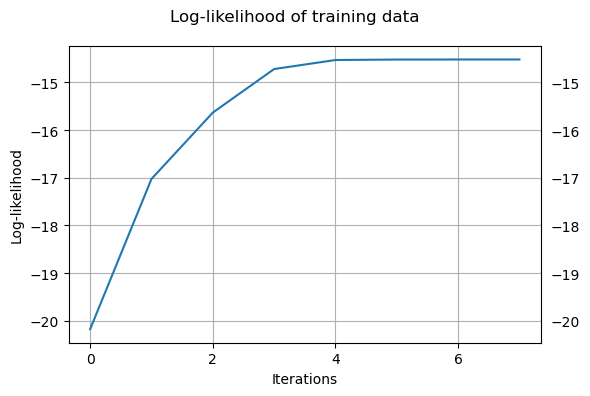

In [11]:
# Visualization of the log-likelihood along iterations
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4), layout='tight')
fig.suptitle('Log-likelihood of training data')
ax.grid(True)
ax.tick_params(labelright=True)
ax.set_ylabel('Log-likelihood')
ax.set_xlabel('Iterations')
ax.set_xticks(np.arange(0, nb_iter+1, 2))
ax.plot(np.arange(nb_iter+1), log_likelihood)

In [12]:
# Estimates for the unknown parameters
print ('Les estimations pour les paramètres inconnus sont :')
print ('nu = ', nu_estim, '\n')
print ('Q =\n', Q_estim, '\n')
print ('mu = ', mu_estim, '\n')
print ('v = ', v_estim)

Les estimations pour les paramètres inconnus sont :
nu =  [2.39685177e-95 1.00000000e+00] 

Q =
 [[2.07607196e-05 9.99979239e-01]
 [6.63108584e-01 3.36891416e-01]] 

mu =  [ 0.44195463 -2.30546475] 

v =  [0.18642977 0.98160862]


**Remarque:** On peut observer que bien que la logvraisemblance augmente à chaque itération, les estimations ne convergent pas vers les vraies valeurs des paramètres inconnus.

### <font color=darkorange> Discussion </font>

In [13]:
def EM_algorithm_without_loglik(samples, r, Q0, nu0, mu0, v0, IterMax):
    """
    Inputs
    ----------
    samples: data/observations (Y_k)
    r: number of values of Markov chain
    Q0: initialization of transition matrix Q of Markov chain
    nu0: initialization of initial law nu of Markov chain
    mu0, v0: initializations of means mu and variances v of obeservations (Y_k) given Markov chain (X_k)
    IterMax: maximum number of iterations
    
    Outputs
    -------
    Q_estim: estimates of Q along iterations
    nu_estim: estimates of nu along iterations
    mu_estim, v_estim: estimates of mu and v along iterations
    """
    
    Q_estim, nu_estim, mu_estim, v_estim = Q0, nu0, mu0, v0
    Q_list_est, nu_list_est, mu_list_est, v_list_est = [Q_estim.flatten()], [nu_estim], [mu_estim], [v_estim]
    
    for p in range(IterMax):
        omega_tilde, omega = Omega(samples, r, Q_estim, nu_estim, mu_estim, v_estim)
        sum_omega_tilde = np.sum(omega_tilde, axis=0)
        mu_estim = np.sum(omega_tilde*samples[:, np.newaxis], axis=0)/sum_omega_tilde
        v_estim = np.sum(omega_tilde*(samples[:, np.newaxis]-mu_estim)**2, axis=0)/sum_omega_tilde
        nu_estim = omega_tilde[0]
        Q_estim = np.sum(omega, axis=-1)/(np.sum(omega_tilde[:-1,:], axis=0)[:, np.newaxis])
        Q_list_est.append(Q_estim.flatten())
        nu_list_est.append(nu_estim)
        mu_list_est.append(mu_estim)
        v_list_est.append(v_estim)
        
    return np.array(Q_list_est), np.array(nu_list_est), np.array(mu_list_est), np.array(v_list_est)

#### Temps du calcul des $\tilde \omega^{\theta}$ et $\omega^{\theta}$ (Déjà abordée ci-dessus)

#### Sensibilité aux différents paramètres

> **Nombre d'observations et d'iterations** 

In [14]:
nb_iterations = 200
# Estimates with 100 data
Q_est_100, nu_est_100, mu_est_100, v_est_100 = EM_algorithm_without_loglik(samples[:100], r, Q_test, nu_test, mu_test, v_test, nb_iterations)
# Estimates with 500 data
Q_est_1000, nu_est_1000, mu_est_1000, v_est_1000 = EM_algorithm_without_loglik(samples, r, Q_test, nu_test, mu_test, v_test, nb_iterations)

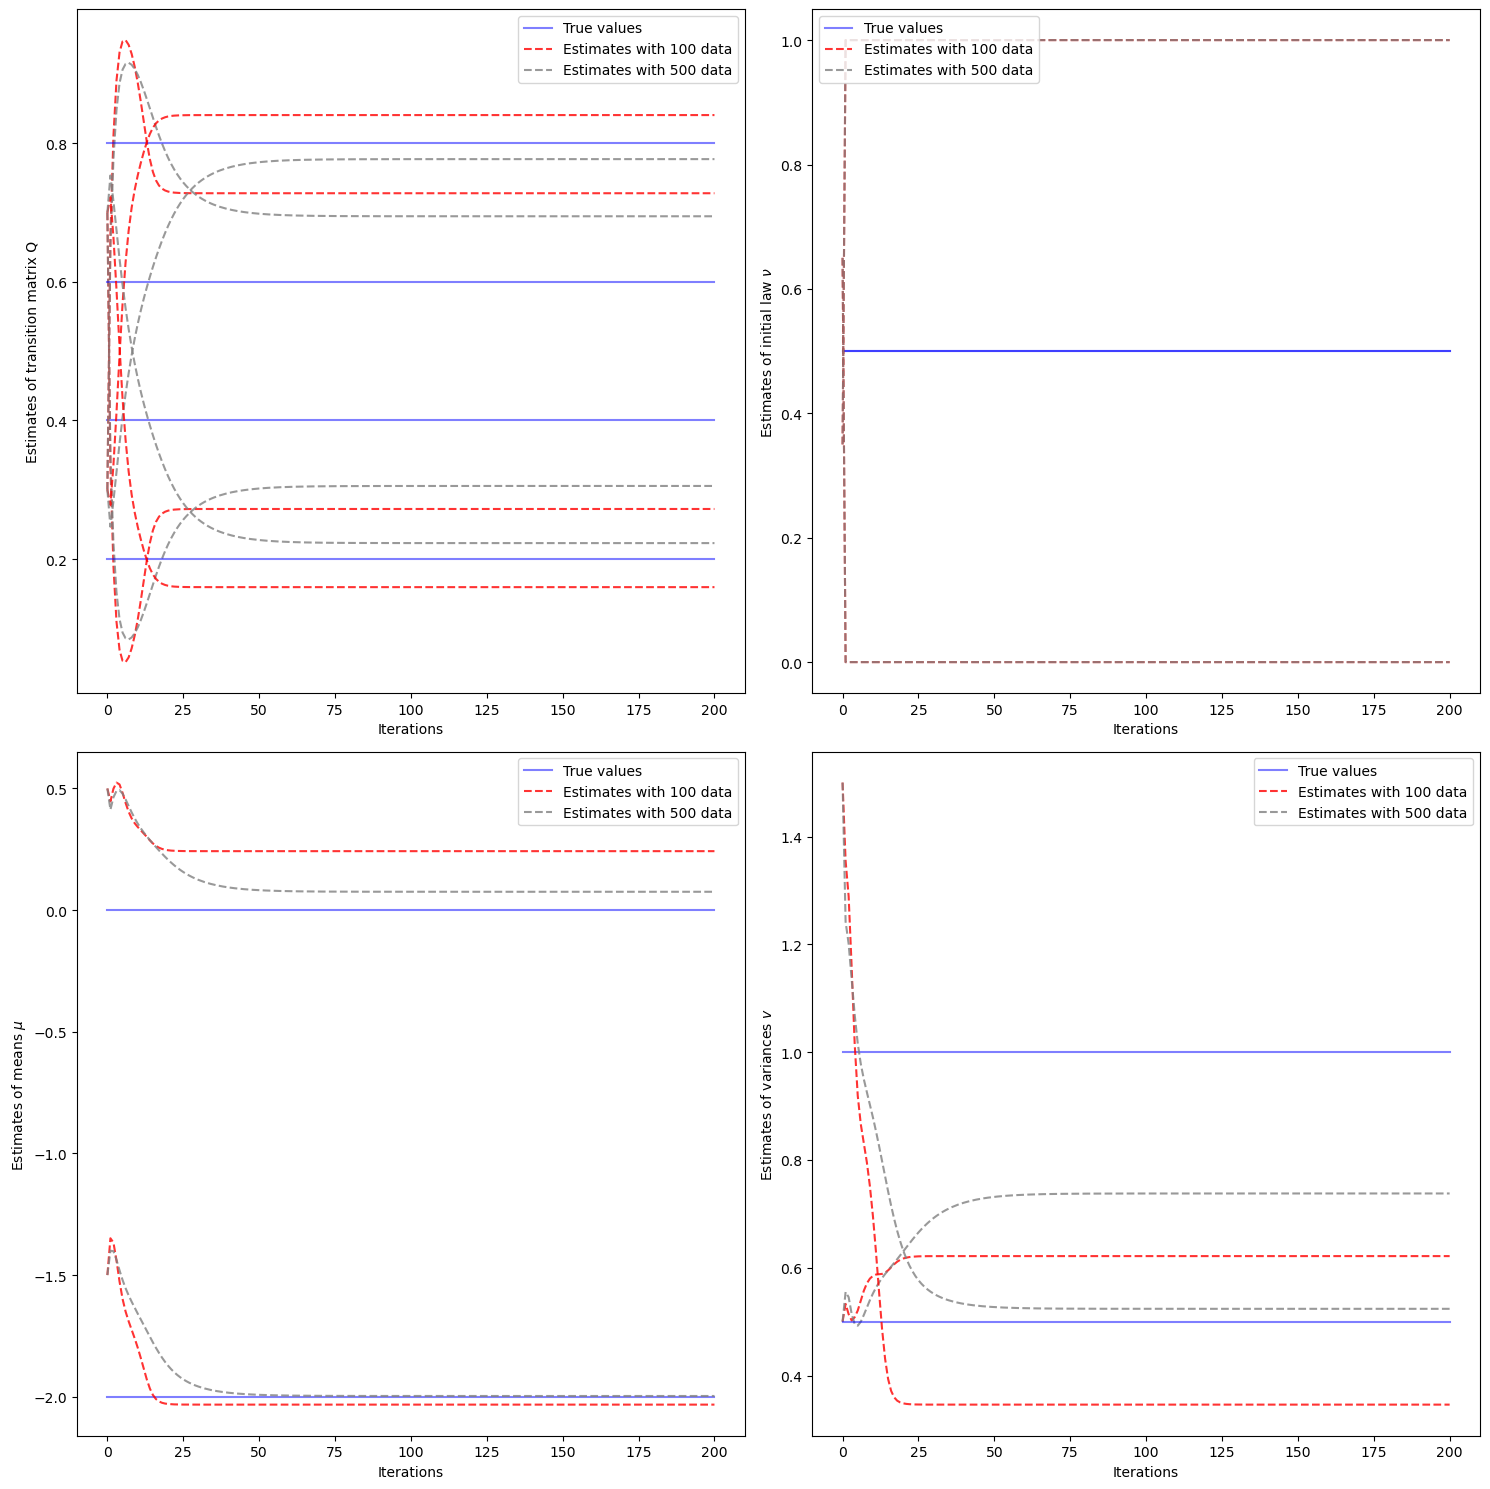

In [15]:
colors = ['blue', 'red', 'grey']
labels = ['True values', 'Estimates with 100 data', 'Estimates with 500 data']
linestyles = ['solid', 'dashed', 'dashed']
colors_ploted = []
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), layout='tight')

# Plot estimates of transition matrix Q
for i in range(r*r):
    axs[0][0].plot(np.arange(nb_iterations+1), np.array([Q.flatten()[i]]*(nb_iterations+1)), alpha=0.5,
                   linestyle=linestyles[0], color=colors[0], label=labels[0] if colors[0] not in colors_ploted else '')
    axs[0][0].plot(np.arange(nb_iterations+1), Q_est_100[:, i], alpha=0.8,
                   linestyle=linestyles[1], color=colors[1], label=labels[1] if colors[1] not in colors_ploted else '')
    axs[0][0].plot(np.arange(nb_iterations+1), Q_est_1000[:, i], alpha=0.8,
                   linestyle=linestyles[2], color=colors[2], label=labels[2] if colors[2] not in colors_ploted else '')
    colors_ploted.append(colors[0])
    colors_ploted.append(colors[1])
    colors_ploted.append(colors[2])
axs[0][0].legend()
axs[0][0].set_ylabel(r'Estimates of transition matrix Q')
axs[0][0].set_xlabel('Iterations')
colors_ploted.clear()

# Plot estimates of initial law nu
for i in range(r):
    axs[0][1].plot(np.arange(nb_iterations+1), np.array([nu[i]]*(nb_iterations+1)), alpha=0.5,
                   linestyle=linestyles[0], color=colors[0], label=labels[0] if colors[0] not in colors_ploted else '')
    axs[0][1].plot(np.arange(nb_iterations+1), nu_est_100[:, i], alpha=0.8,
                   linestyle=linestyles[1], color=colors[1], label=labels[1] if colors[1] not in colors_ploted else '')
    axs[0][1].plot(np.arange(nb_iterations+1), nu_est_1000[:, i], alpha=0.8,
                   linestyle=linestyles[2], color=colors[2], label=labels[2] if colors[2] not in colors_ploted else '')
    colors_ploted.append(colors[0])
    colors_ploted.append(colors[1])
    colors_ploted.append(colors[2])
axs[0][1].legend()
axs[0][1].set_ylabel(r'Estimates of initial law $\nu$')
axs[0][1].set_xlabel('Iterations')
colors_ploted.clear()

# Plot estimates of means mu
for i in range(r):
    axs[1][0].plot(np.arange(nb_iterations+1), np.array([mu[i]]*(nb_iterations+1)), alpha=0.5,
                   linestyle=linestyles[0], color=colors[0], label=labels[0] if colors[0] not in colors_ploted else '')
    axs[1][0].plot(np.arange(nb_iterations+1), mu_est_100[:, i], alpha=0.8,
                   linestyle=linestyles[1], color=colors[1], label=labels[1] if colors[1] not in colors_ploted else '')
    axs[1][0].plot(np.arange(nb_iterations+1), mu_est_1000[:, i], alpha=0.8,
                   linestyle=linestyles[2], color=colors[2], label=labels[2] if colors[2] not in colors_ploted else '')
    colors_ploted.append(colors[0])
    colors_ploted.append(colors[1])
    colors_ploted.append(colors[2])
axs[1][0].legend()
axs[1][0].set_ylabel(r'Estimates of means $\mu$')
axs[1][0].set_xlabel('Iterations')
colors_ploted.clear()

# Plot estimates of variances v
for i in range(r):
    axs[1][1].plot(np.arange(nb_iterations+1), np.array([v[i]]*(nb_iterations+1)), alpha=0.5,
                   linestyle=linestyles[0], color=colors[0], label=labels[0] if colors[0] not in colors_ploted else '')
    axs[1][1].plot(np.arange(nb_iterations+1), v_est_100[:, i], alpha=0.8,
                   linestyle=linestyles[1], color=colors[1], label=labels[1] if colors[1] not in colors_ploted else '')
    axs[1][1].plot(np.arange(nb_iterations+1), v_est_1000[:, i], alpha=0.8,
                   linestyle=linestyles[2], color=colors[2], label=labels[2] if colors[2] not in colors_ploted else '')
    colors_ploted.append(colors[0])
    colors_ploted.append(colors[1])
    colors_ploted.append(colors[2])
axs[1][1].legend()
axs[1][1].set_ylabel(r'Estimates of variances $v$')
axs[1][1].set_xlabel('Iterations')
colors_ploted.clear()

**Conclusion:** 
1. Si l'on dispose de plus d'observations, les estimations seront plus précises, sauf pour l'estimation de $\nu$.
2. À partir d'un certain nombre d'iterations, il n'y a pas de changements significatifs dans les estimations.

> **Estimations initiales**

In [16]:
nb_iterations = 80
Q_est1, nu_est1, mu_est1, v_est1 = EM_algorithm_without_loglik(samples[:100], r, Q_test, nu_test, mu_test, v_test, nb_iterations)
Q_est2, nu_est2, mu_est2, v_est2 = EM_algorithm_without_loglik(samples[:100], r, Q, nu, mu, v, nb_iterations)

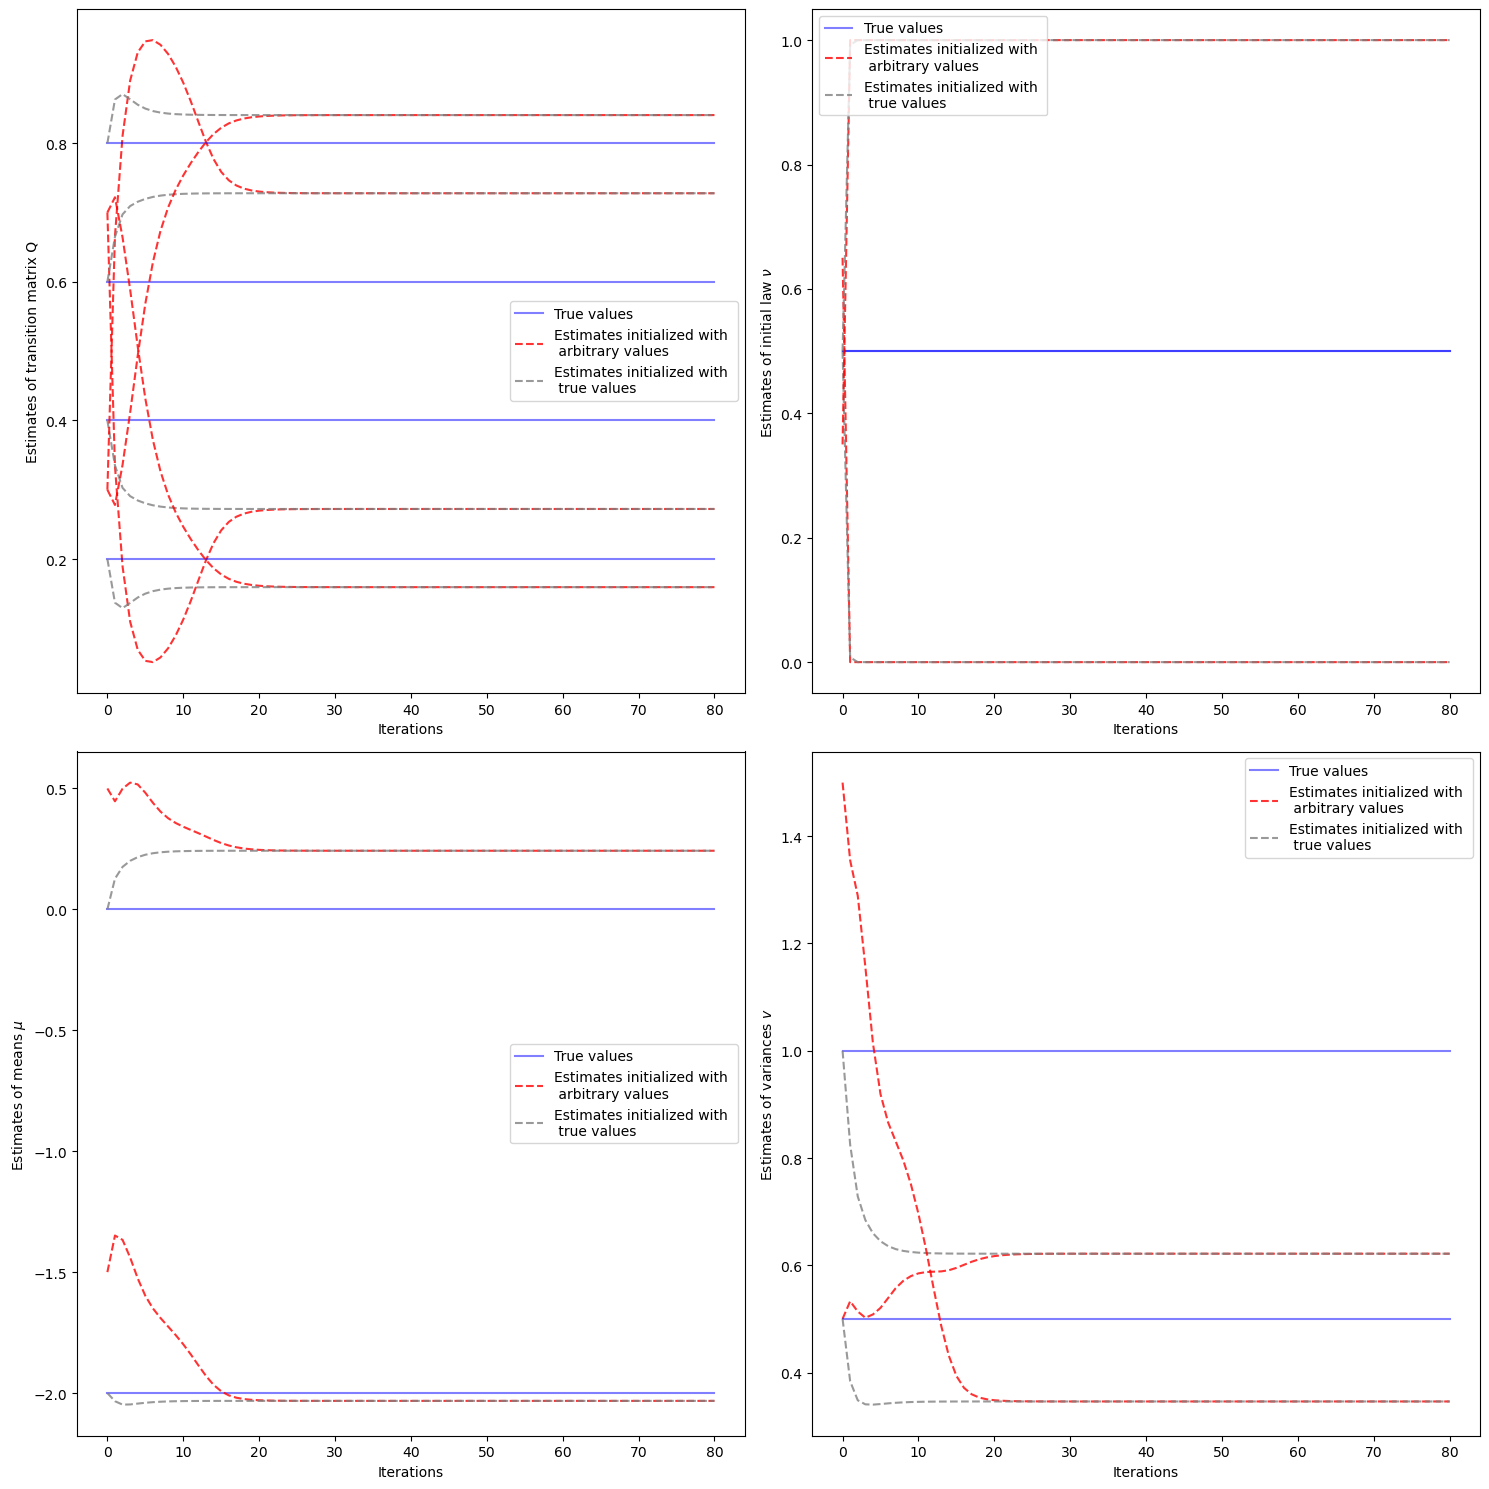

In [17]:
labels = ['True values', 'Estimates initialized with \n arbitrary values', 'Estimates initialized with \n true values']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), layout='tight')

# Plot estimates of transition matrix Q
for i in range(r*r):
    axs[0][0].plot(np.arange(nb_iterations+1), np.array([Q.flatten()[i]]*(nb_iterations+1)), alpha=0.5,
                   linestyle=linestyles[0], color=colors[0], label=labels[0] if colors[0] not in colors_ploted else '')
    axs[0][0].plot(np.arange(nb_iterations+1), Q_est1[:, i], alpha=0.8,
                   linestyle=linestyles[1], color=colors[1], label=labels[1] if colors[1] not in colors_ploted else '')
    axs[0][0].plot(np.arange(nb_iterations+1), Q_est2[:, i], alpha=0.8,
                   linestyle=linestyles[2], color=colors[2], label=labels[2] if colors[2] not in colors_ploted else '')
    colors_ploted.append(colors[0])
    colors_ploted.append(colors[1])
    colors_ploted.append(colors[2])
axs[0][0].legend()
axs[0][0].set_ylabel(r'Estimates of transition matrix Q')
axs[0][0].set_xlabel('Iterations')
colors_ploted.clear()

# Plot estimates of initial law nu
for i in range(r):
    axs[0][1].plot(np.arange(nb_iterations+1), np.array([nu[i]]*(nb_iterations+1)), alpha=0.5,
                   linestyle=linestyles[0], color=colors[0], label=labels[0] if colors[0] not in colors_ploted else '')
    axs[0][1].plot(np.arange(nb_iterations+1), nu_est1[:, i], alpha=0.8,
                   linestyle=linestyles[1], color=colors[1], label=labels[1] if colors[1] not in colors_ploted else '')
    axs[0][1].plot(np.arange(nb_iterations+1), nu_est2[:, i], alpha=0.8,
                   linestyle=linestyles[2], color=colors[2], label=labels[2] if colors[2] not in colors_ploted else '')
    colors_ploted.append(colors[0])
    colors_ploted.append(colors[1])
    colors_ploted.append(colors[2])
axs[0][1].legend()
axs[0][1].set_ylabel(r'Estimates of initial law $\nu$')
axs[0][1].set_xlabel('Iterations')
colors_ploted.clear()

# Plot estimates of means mu
for i in range(r):
    axs[1][0].plot(np.arange(nb_iterations+1), np.array([mu[i]]*(nb_iterations+1)), alpha=0.5,
                   linestyle=linestyles[0], color=colors[0], label=labels[0] if colors[0] not in colors_ploted else '')
    axs[1][0].plot(np.arange(nb_iterations+1), mu_est1[:, i], alpha=0.8,
                   linestyle=linestyles[1], color=colors[1], label=labels[1] if colors[1] not in colors_ploted else '')
    axs[1][0].plot(np.arange(nb_iterations+1), mu_est2[:, i], alpha=0.8,
                   linestyle=linestyles[2], color=colors[2], label=labels[2] if colors[2] not in colors_ploted else '')
    colors_ploted.append(colors[0])
    colors_ploted.append(colors[1])
    colors_ploted.append(colors[2])
axs[1][0].legend()
axs[1][0].set_ylabel(r'Estimates of means $\mu$')
axs[1][0].set_xlabel('Iterations')
colors_ploted.clear()

# Plot estimates of variances v
for i in range(r):
    axs[1][1].plot(np.arange(nb_iterations+1), np.array([v[i]]*(nb_iterations+1)), alpha=0.5,
                   linestyle=linestyles[0], color=colors[0], label=labels[0] if colors[0] not in colors_ploted else '')
    axs[1][1].plot(np.arange(nb_iterations+1), v_est1[:, i], alpha=0.8,
                   linestyle=linestyles[1], color=colors[1], label=labels[1] if colors[1] not in colors_ploted else '')
    axs[1][1].plot(np.arange(nb_iterations+1), v_est2[:, i], alpha=0.8,
                   linestyle=linestyles[2], color=colors[2], label=labels[2] if colors[2] not in colors_ploted else '')
    colors_ploted.append(colors[0])
    colors_ploted.append(colors[1])
    colors_ploted.append(colors[2])
axs[1][1].legend()
axs[1][1].set_ylabel(r'Estimates of variances $v$')
axs[1][1].set_xlabel('Iterations')
colors_ploted.clear()

**Conclusion:** Les estimations ne semblent pas sensibles aux estimations initiales.

**Références:** 
- C. Bishop, Pattern Recognition and Machine Learning, 2006, Springer.
- M. Jordan, An Introdution to Probabilistic Graphial Models, 2003.